<a href="https://colab.research.google.com/github/nanochiplab/Sayisal_Goruntu/blob/main/Odev_TopluCizim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloning into 'AI-for-Medicine-Specialization'...
remote: Enumerating objects: 1601, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 1601 (delta 9), reused 2 (delta 0), pack-reused 1573 (from 1)
Receiving objects: 100% (1601/1601), 720.36 MiB | 22.91 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Updating files: 100% (1497/1497), done.
/content/AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis
There are 1000 rows and 16 columns in this data frame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               1000 non-null   object
 1   Atelectasis         1000 non-null   int64 
 2   Cardiomegaly        1000 non-null   int64 
 3   Consolidation       1000 non-null   int64 
 4   Edema               1000 non-null   int64 
 5   Effusion            1000 n

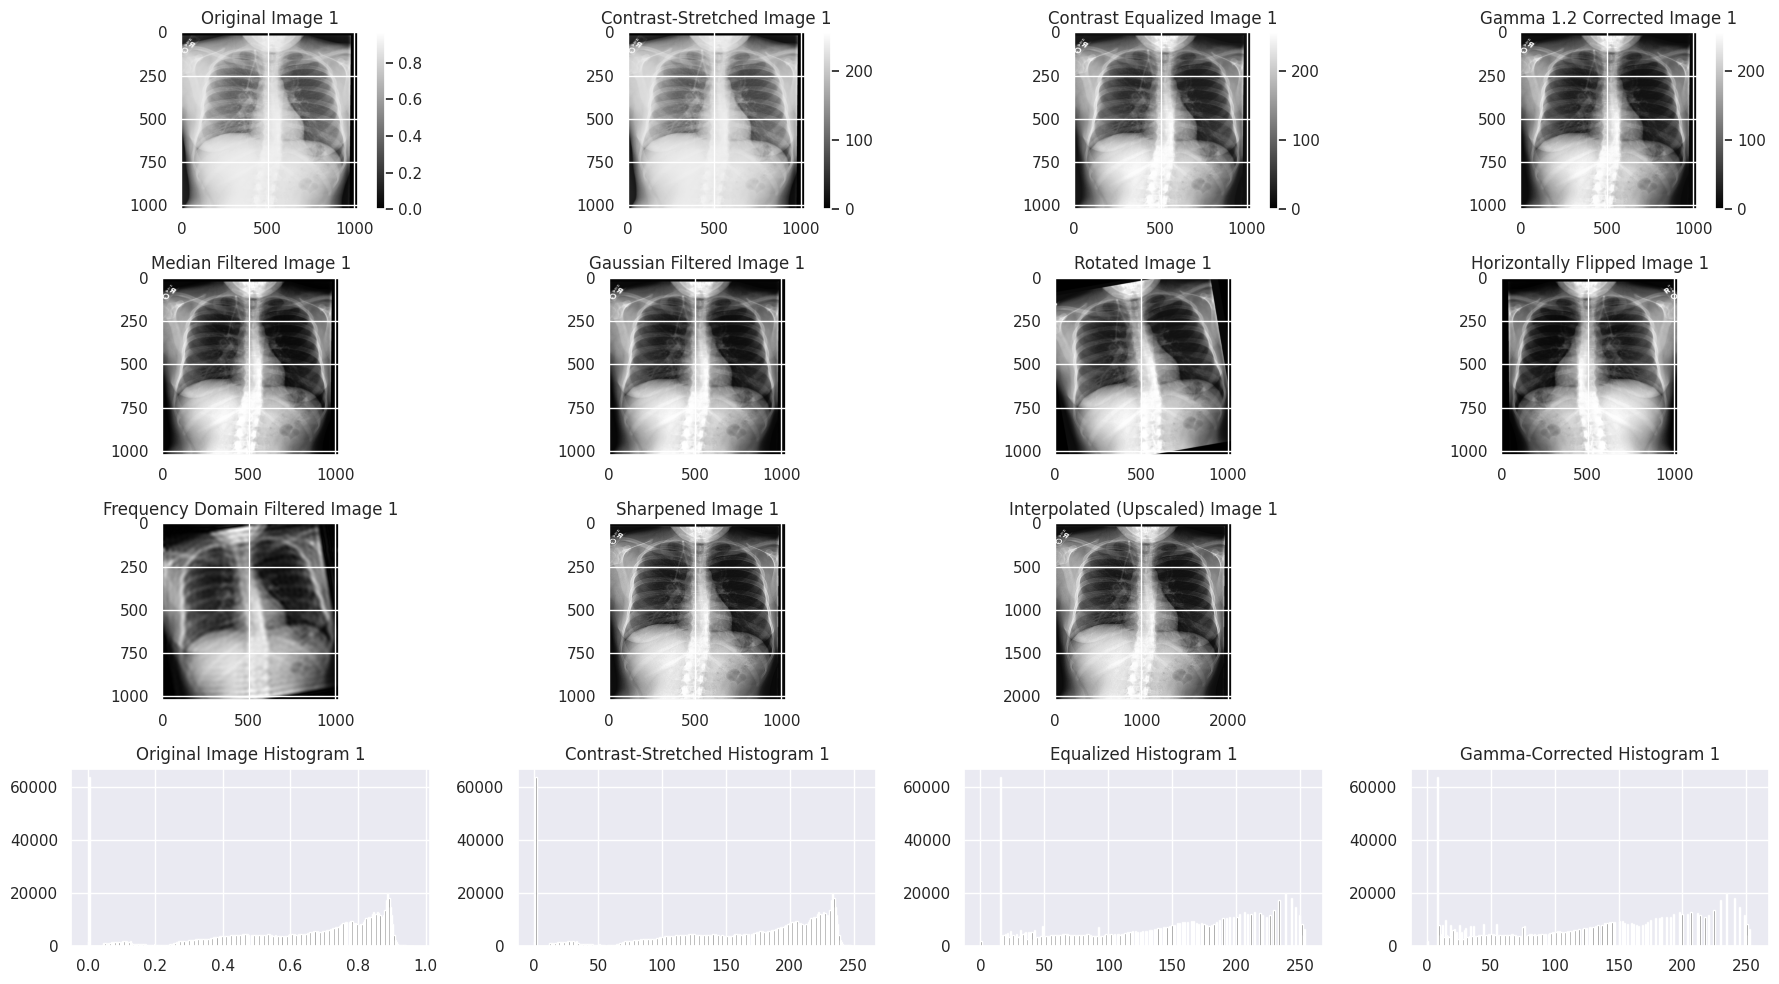

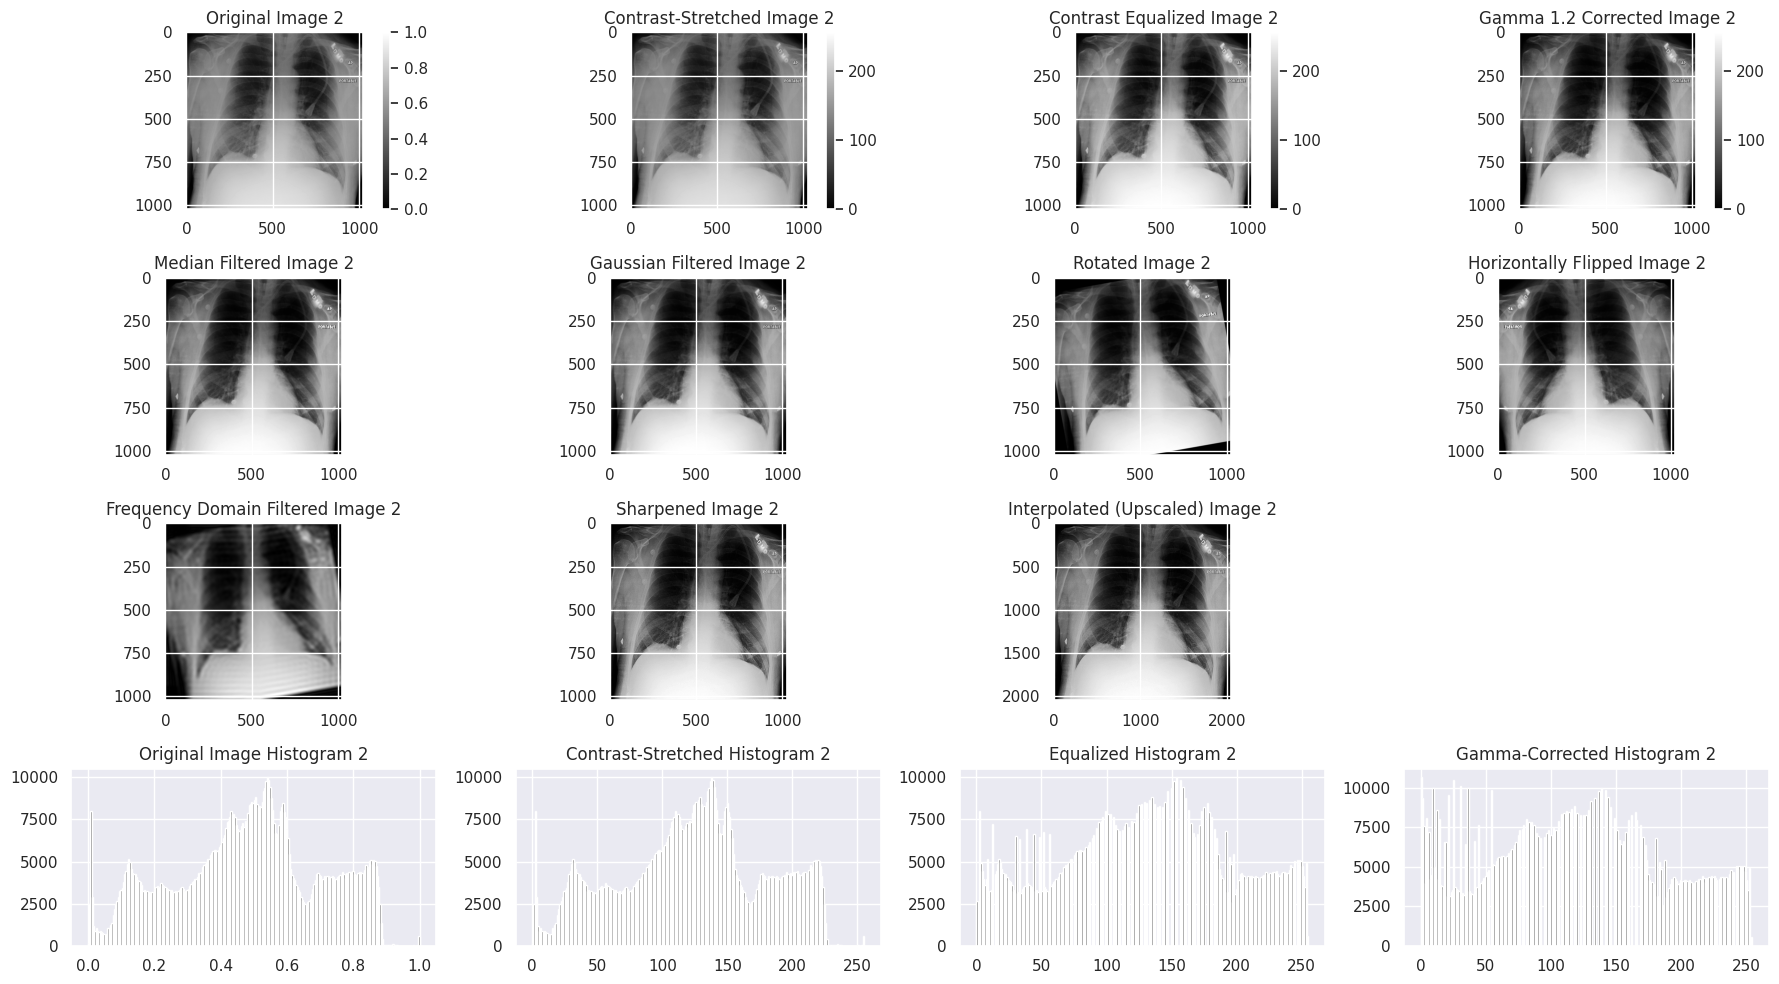

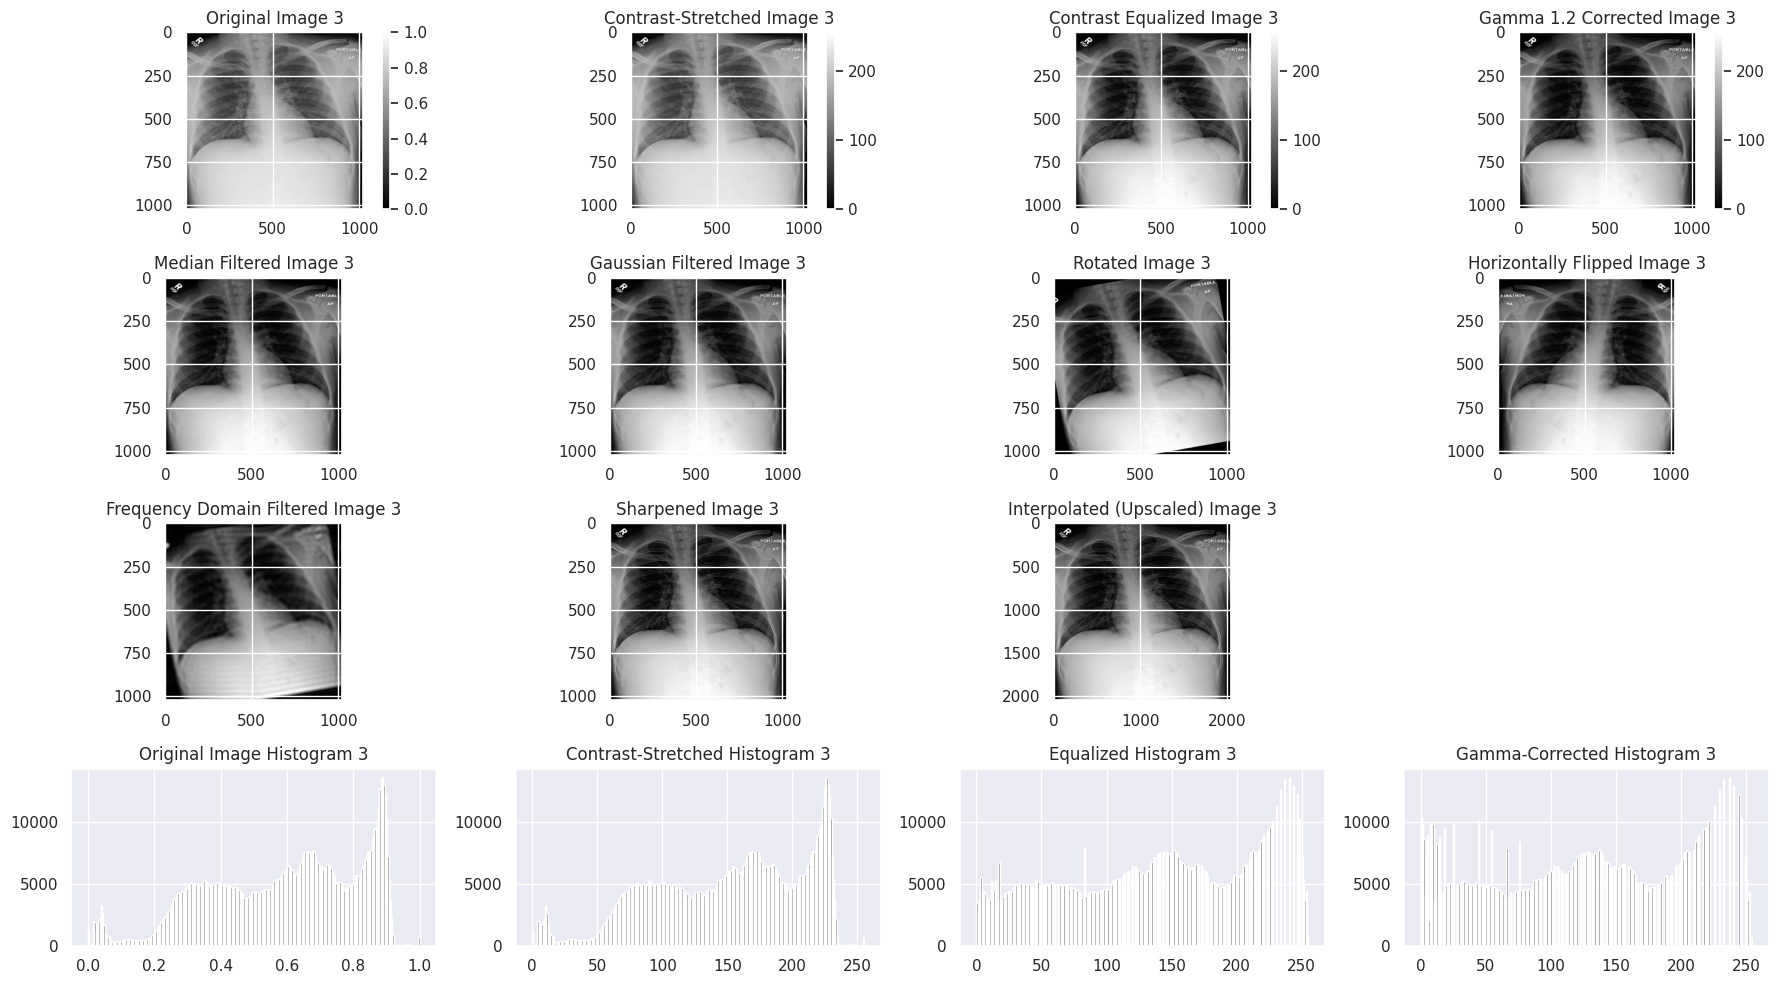

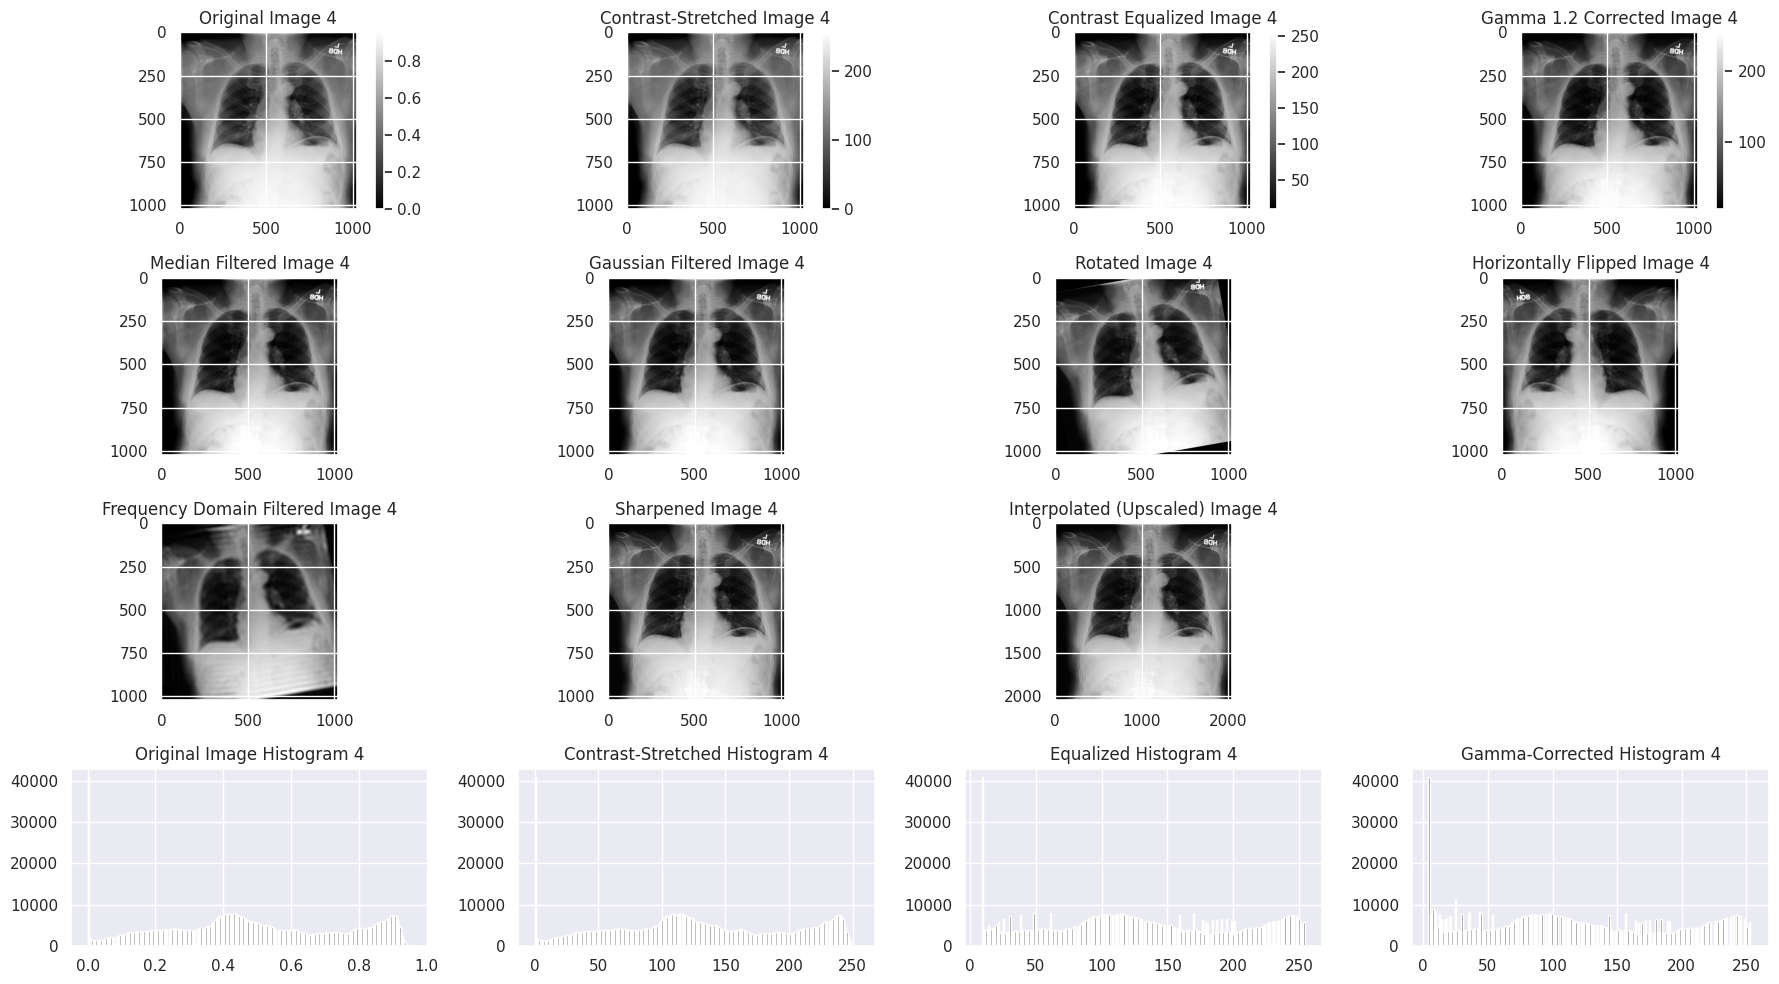

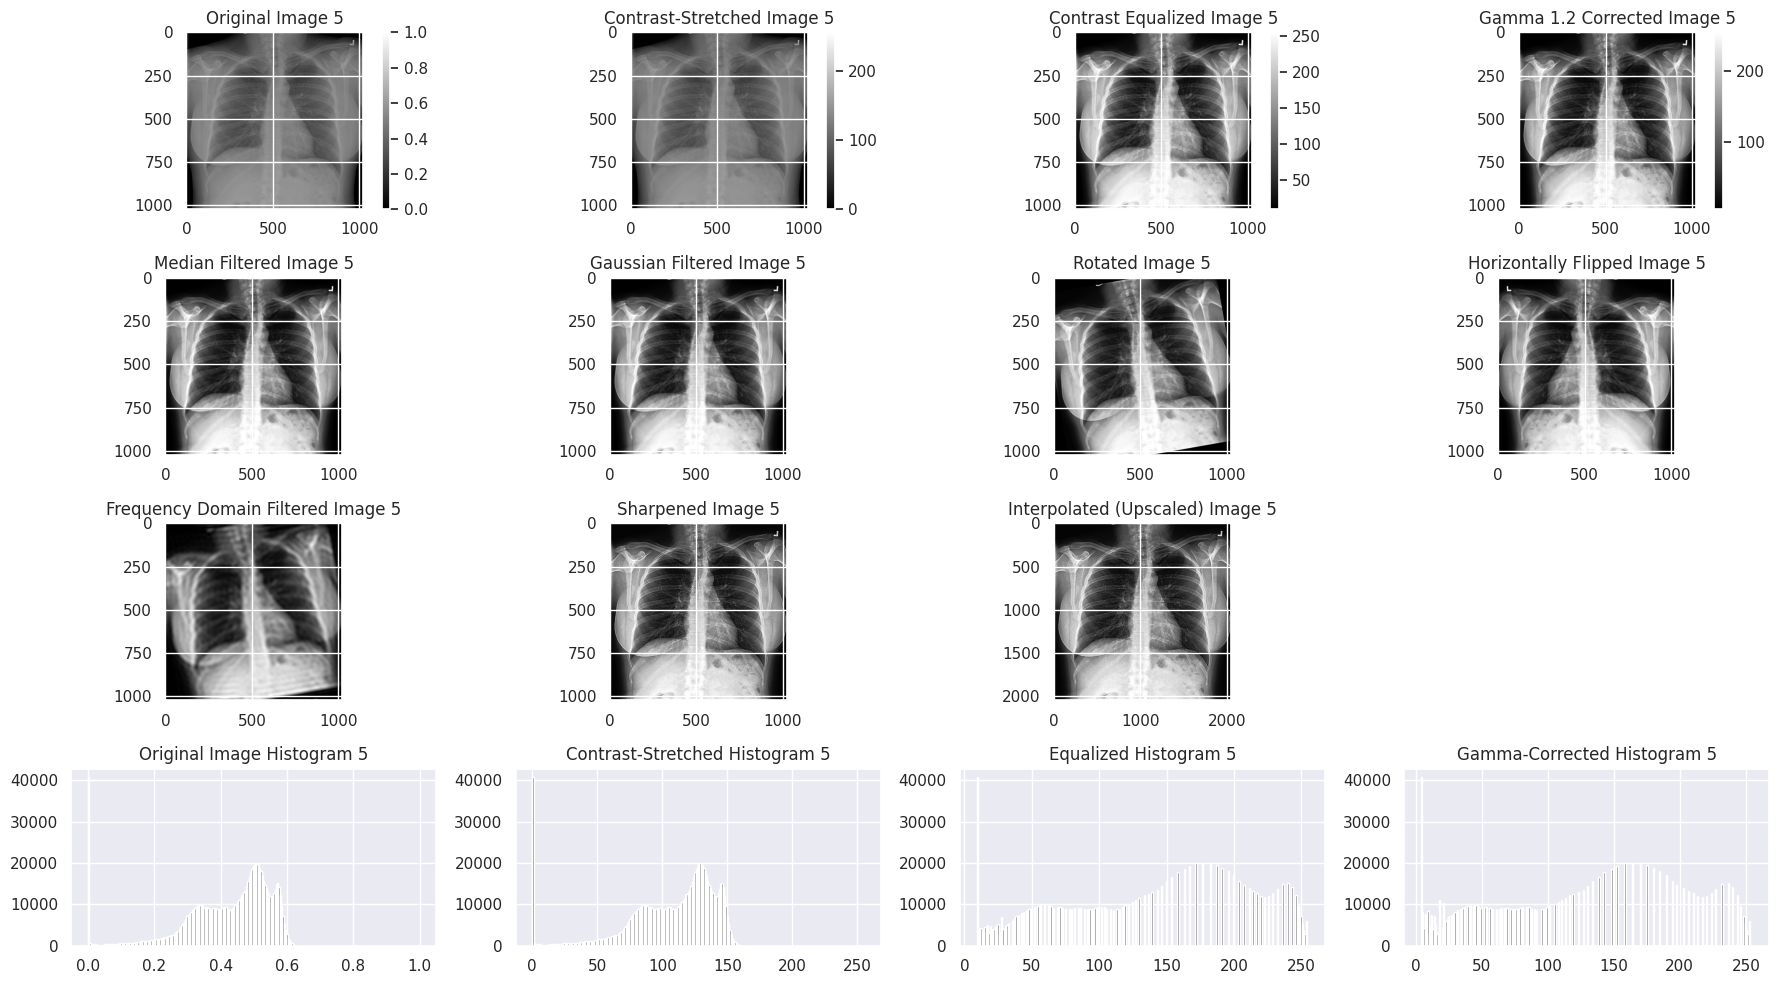

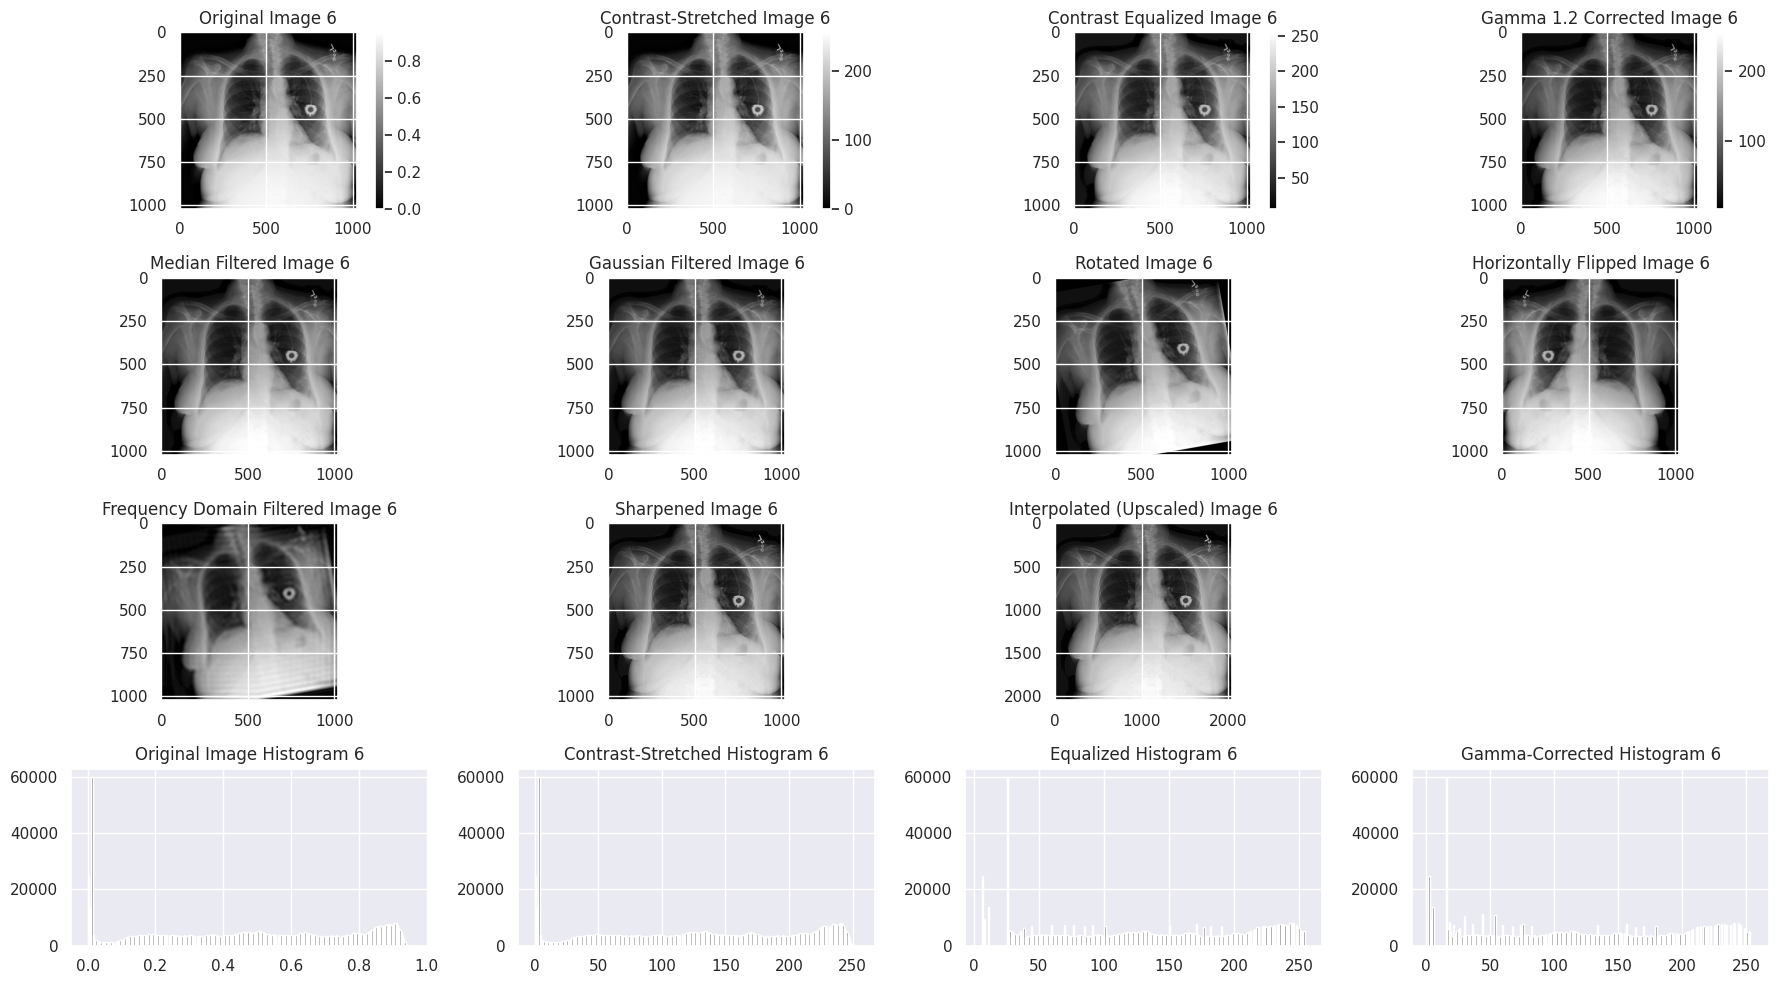

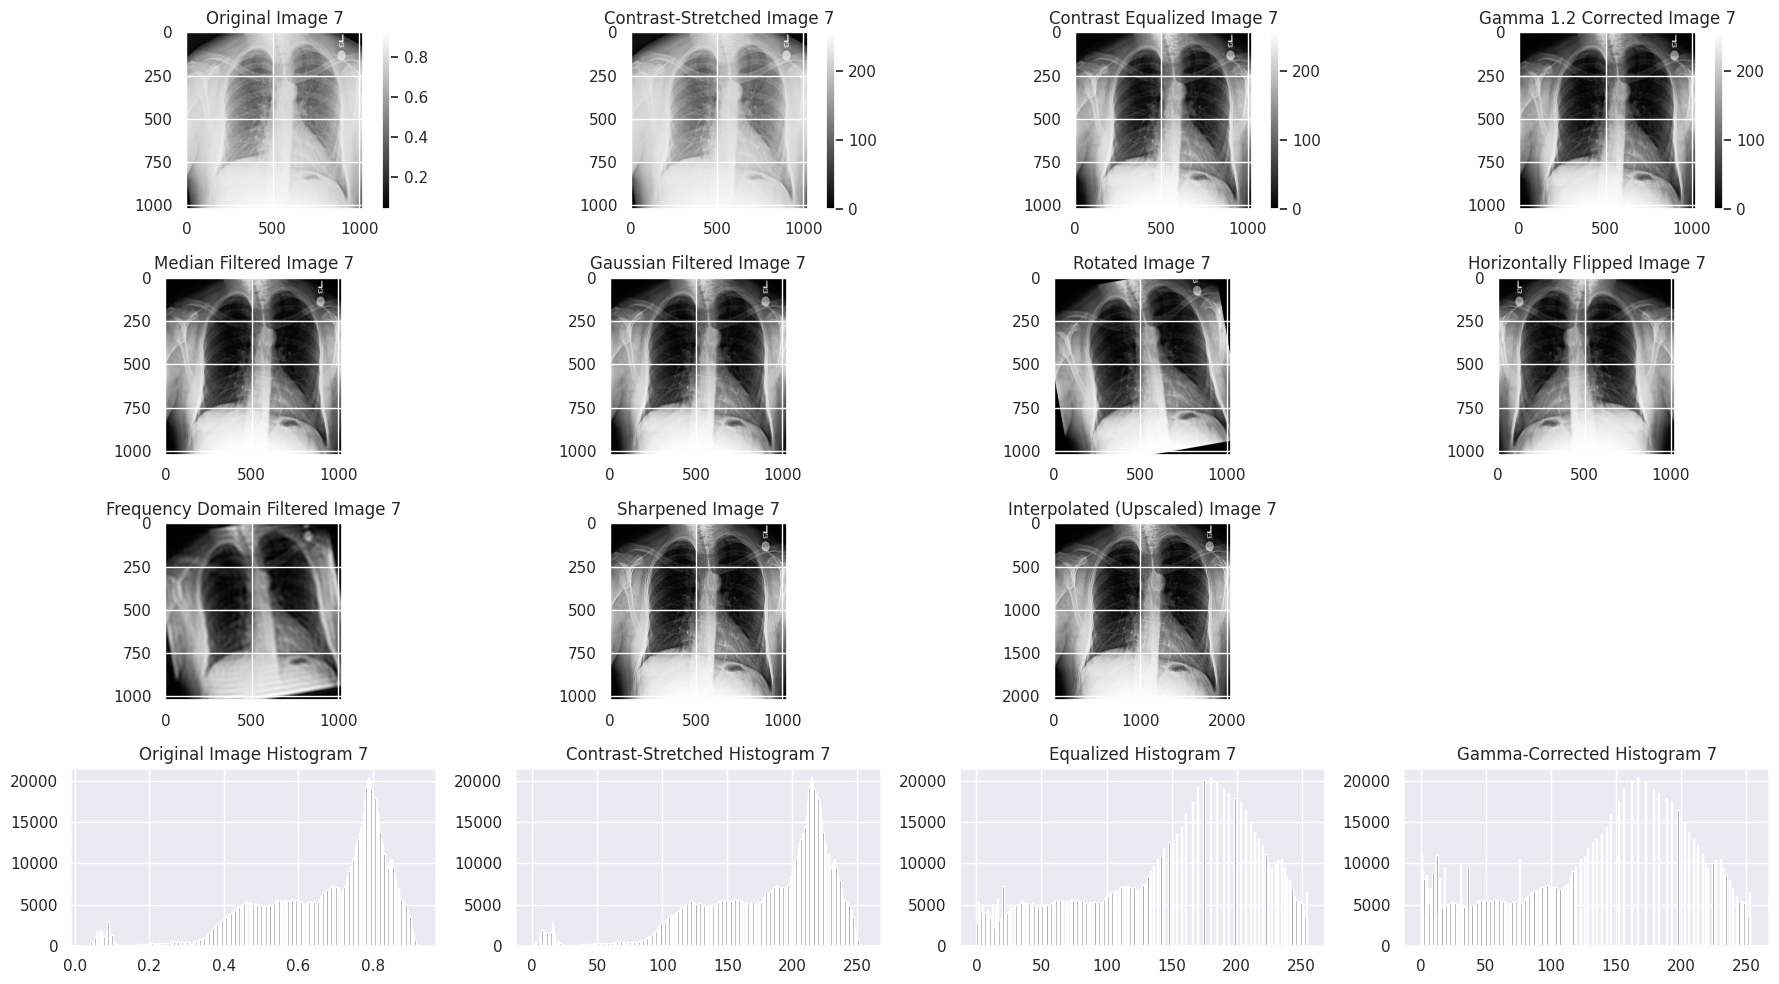

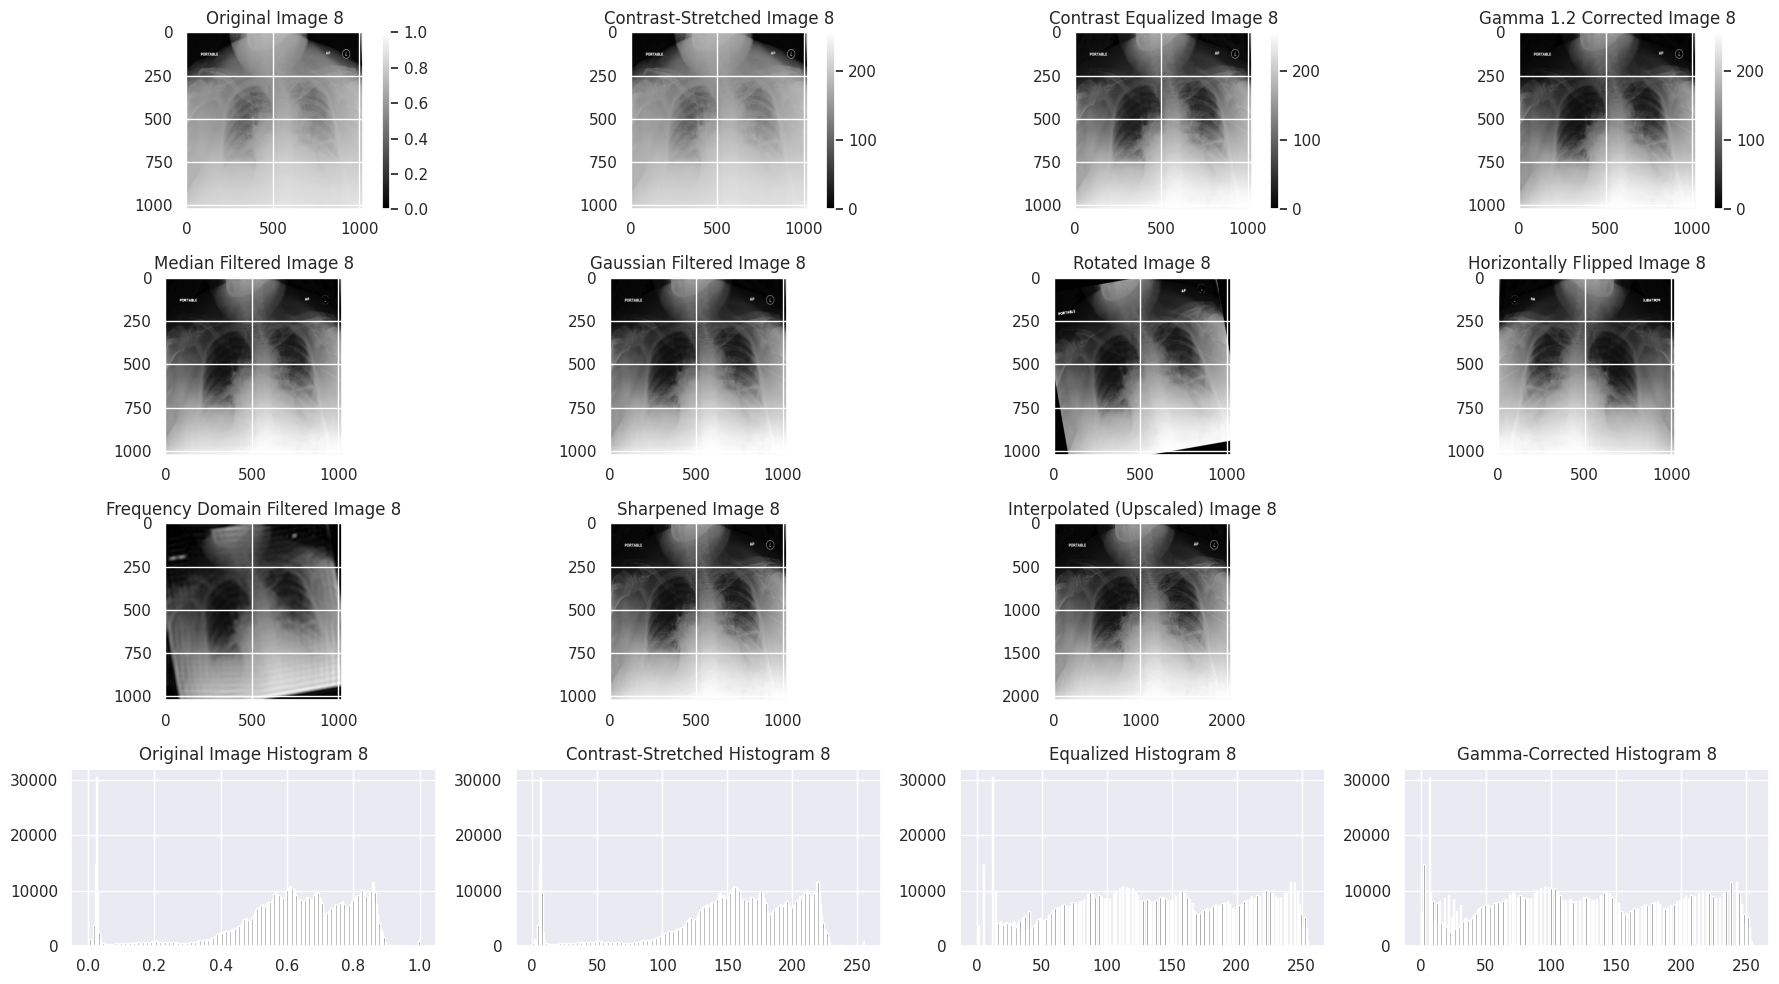

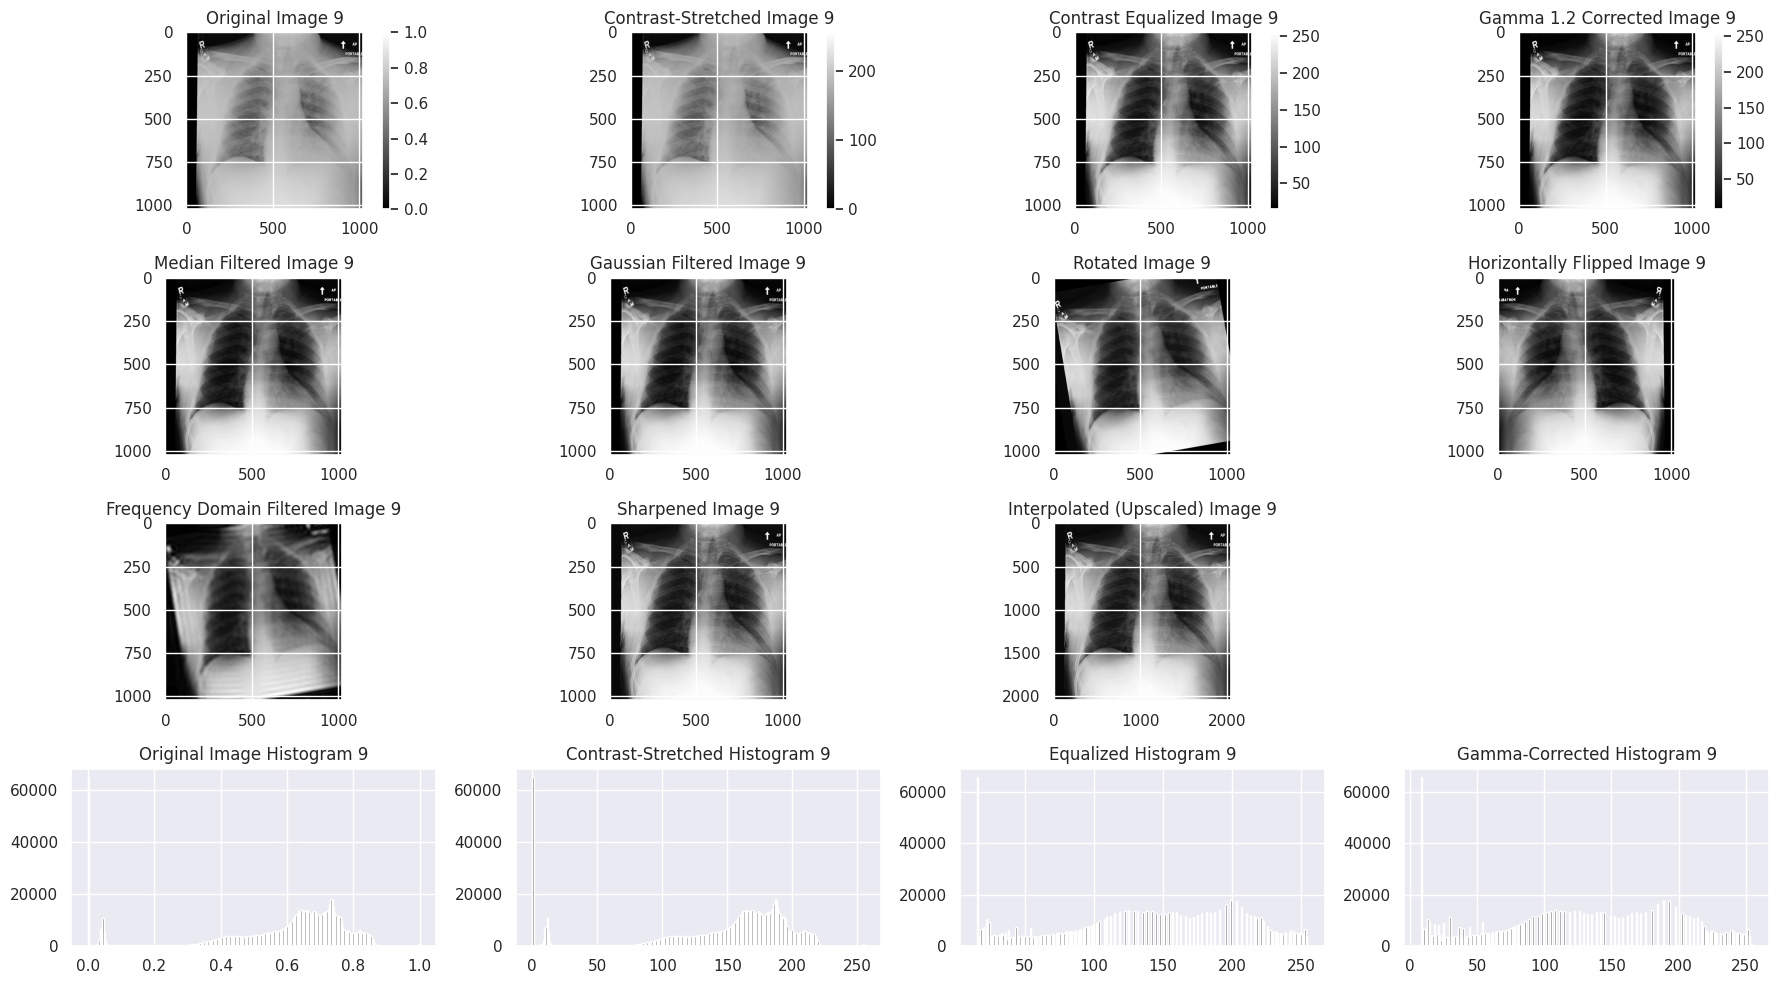

In [ ]:
# Gerekli Kütüphaneleri yüklüyoruz
import pandas as pd                   #Pandas tablo formatındaki verilerle çalışmak içn
import numpy as np                    #diziler üzerinde sayısal işlemler için
import matplotlib.pyplot as plt       #görselleştirmeler oluşturmak için
#çizimleri doğrudan Jupyter Notebook'ta göstermek için
%matplotlib inline
import os                             #işletim sistemiyle etkileşim kurmak (dosyalara erişmek gibi) için
import seaborn as sns                 #çizimlerin estetiğini geliştirmek için
sns.set()                             #mevcut tema style,font ve rengi kullanmak için(değiştirilebilir)
from skimage import exposure          #görüntü işleme işlevleri sağlamak için
import cv2  # opencv for python package  #bilgisayarlı görüş işlemleri için (OpenCV kütüphanesidir)
from scipy.ndimage import zoom        #zoomlama dahil olmak üzere çok boyutlu görüntü işlemleri sağlamak için
                                      #bu kütphaneleri yükledik...............

#Tıbbi görüntü verilerini içeren bir GitHub deposunu klonluyoruz.
#Deponun içindeki belirli klasöre gidiyoruz
!git clone https://github.com/hardik0/AI-for-Medicine-Specialization
%cd AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis/


train_df = pd.read_csv("nih/train-small.csv")  # train-small.csv adlı dosyayı okur ve train_df adlı DataFrame'e yükler
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in this data frame') #Satır ve sütun sayısı, veri türleri ve boş değerler dahil olmak üzere DataFrame hakkında bilgi görüntüler
train_df.head()   #Dataframe'in ilk 5 satırnı döndürür

# Her sütuna null değer var mı yok mu bakalım..
train_df.info()  #Dataframe'in özetini döndürüp yazdırır....
#Toplam "PatientId" sayısını ve benzersiz(unique) PatientId sayısını hesaplar ve yazdırır.
print(f"The total patient ids are {train_df['PatientId'].count()}, from those the unique ids are {train_df['PatientId'].value_counts().shape[0]} ")

columns = train_df.keys()  #columns isimli listeye,Dataframe'deki sütun isimlerini döndürür...
columns = list(columns)    #column'u listele...
print(columns)             #listeyi yazdır.....

# Gereksiz elemanları kaldır
columns.remove('Image')      #Image sütununu kaldır...
columns.remove('PatientId')  #PatientId sütununu kaldır...
# Geriye kalan sütunlrı yazdır..
print(f"There are {len(columns)} columns of labels for these conditions: {columns}")

# Print out the number of positive labels for each class
for column in columns:   #
    print(f"The class {column} has {train_df[column].sum()} samples") #örnek sayısını yazdırır...

#'Image' sütunundan görüntü dosyası isimlerini alır ve bunları images değişkenine atar
images = train_df['Image'].values

# 9 görüntü dosyasını rastgele seçer ve bunları random_images'e atar....
random_images = [np.random.choice(images) for i in range(9)]

#Görüntülerin bulunduğu dizini belirtir (img_dir)....
img_dir = 'nih/images_small/'

print('Display Random Images') #Random(Rastgele) görüntülerin görüntüleneceğini belirten bir mesaj yazdırır...

for i in range(9):        #9 adet görüntü ile çalışacağız..
    #Görüntülerin bulunduğu dizini okur ve for döngüsü dahilinde sırayla raw_image'e atar...
    raw_image = plt.imread(os.path.join(img_dir, random_images[i]))

    #************************ KONTRAST GERME(Contrast Stretching)****************
    # Adım 1: Kontrast iyileştirme yapılacak.......
    #raw_image'deki minimum ve maksimum yoğunluk değerlerini bulur ve atar...
    min_val, max_val = raw_image.min(), raw_image.max()
    #Yoğunluk değerlerini tüm aralığı (0-255) kapsayacak şekilde stretch(gererek) görüntünün kontrastını iyileştireceğiz..
    contrast_stretched = (raw_image - min_val) / (max_val - min_val)  # [0, 1] aralığında normalize eder..
    contrast_stretched = (contrast_stretched * 255).astype(np.uint8)  # Normalize edilen değerleri piksel yoğunluğunu #göstermek için 0-255 aralığında ölçeklendirir...

    #**************************HİSTOGRAM DENKLEŞTİRME******
    # Adım 2: Piksel yoğunlukları histogram boyunca daha eşit bir şekilde dağıtılarak kontrast daha da artırılacak...
    #Skimage kütüphanesinden exposure.equalize_hist işlevini kullanarak contrast_stretched görüntüsüne #histogram denkleştirme uygulayacağız.....
    equalized_image = exposure.equalize_hist(contrast_stretched)  #Çıkış değerleri 0-1 aralığında
    equalized_image = (equalized_image * 255).astype(np.uint8)    #Piksel değerleri 0-255 aralığında ve veri tipi 8 bitlik işaretsiz tamsayıya çevrildi

    #**************************GAMA DÜZELTME**************
    # Adım 3: Gama Düzeltmesi uygulanacak....
    gamma = 1.2  #Görüntünün parlaklığını kontrol eden gama değerini ayarlar.1'den büyük bir gama değeri görüntüyü aydınlatırken, 1'den küçük bir değer görüntüyü koyulaştırır.
    gamma_corrected = np.power(equalized_image / 255.0, gamma) * 255 #Eşitlenmiş görüntüye gama düzeltmesi uygular.İlk önce piksel değerlerini [0, 1] aralığına normalleştirir, ardından bunları
    #gama kuvvetine yükseltir ve son olarak bunları [0, 255] aralığına geri ölçekler
    gamma_corrected = gamma_corrected.astype(np.uint8) #gamma_corrected'ın veri türünü np.uint8'e 8 bitlik tamsayıya dönüştürür.
    #GAMA DÜZELTMESİNDE PEK BİR DEĞİŞİM GÖZLEYEMEDİM..
    #**************************MEDİAN VE GAUSS FİLTRELEME*********************
    # Adım 4: Gürültü azaltmı yapılacak...
    #gamma_corrected görüntüsüne medyan filtreleme uygulayacağız.Her pikseli komşu piksellerinin medyan değeriyle değiştirerek
    #Median Filtreleme tuz-biber gürültüsünü gidermeye yardımcı olur.
    #BU GÖRÜNTÜDE TUZ BİBER OLMADIĞI İÇİN MEDİAN FİLTRELEME PEK BİR DEĞİŞİM GÖZLEYEMEDİM....
    median_filtered = cv2.medianBlur(gamma_corrected, 5) # 5x5 boyutunda...

    #gamma_corrected görüntüsüne Gauss bulanıklaştırma uygular.Gauss çekirdeği kullanarak görüntüyü bulanıklaştıran başka bir gürültü azaltma tekniğidir.Görüntüyü yumuşatmaya ve yüksek
    #frekanslı gürültüleri azaltmaya yardımcı olur.
    gaussian_filtered = cv2.GaussianBlur(gamma_corrected, (5, 5), 0)

    #**************************GÖRÜNTÜ DÖNÜŞTÜRME***************
    # Adım 5: Görüntü 10 derece döndürülecek..........
    center = (median_filtered.shape[1] // 2, median_filtered.shape[0] // 2)  #Görüntünün merkezini hesaplar....
    rotation_matrix = cv2.getRotationMatrix2D(center, angle=10, scale=1.0) #Görüntüyü merkezinin etrafında 10 derece döndürmek için 2 boyutlu bir dönüş matrisi oluşturur.
    # Yukarıda hesaplanan döndürme matrisini kullanarak median_filtered görüntüsünü dönüştürür.
    #median_filtered.shape[1] ve median_filtered.shape[0], döndürülen görüntünün orijinal boyutlara uymasını sağlamak için görüntünün genişliğini ve yüksekliğini sağlar.
    rotated_image = cv2.warpAffine(median_filtered, rotation_matrix, (median_filtered.shape[1], median_filtered.shape[0]))

    # Horizontal Flip (Yatay Döndürme)
    flipped_horizontal = cv2.flip(median_filtered, 1) # satır median_filtered görüntüsünü yatay olarak çevirir.
    # cv2.flip görüntüleri çevirmek için bir OpenCV fonksiyonudur.
    # 1 argümanı yatay bir çevirmeyi gösterir.

    # *********************FOURİER DÖNÜŞÜMÜ UYGULAMA********************
    # Adım 6: Görüntüye Fourier dönüşümü uygulanarak düşük frekans merkezine kaydırma yapılacak.....
    dft = cv2.dft(np.float32(rotated_image), flags=cv2.DFT_COMPLEX_OUTPUT) # Döndürülmüş_görüntiye Ayrık Fourier Dönüşümünü (DFT) uygular.
    #cv2.dft, görüntüyü uzaysal alandan frekans alanına dönüştürerek DFT'yi hesaplar...
    dft_shifted = np.fft.fftshift(dft) #sıfır frekans bileşenini spektrumun merkezine kaydırır ve böylece filtreleri görselleştirmeyi ve uygulamayı kolaylaştırır.

    #**********************MASKE OLUŞTURMA VE UYGULAMA*******************
    # Adım 7: Maskeleme oluşturulup ve uygulaması yapılacak...
    rows, cols = rotated_image.shape            #görüntünün frekans spektrumundaki
    crow, ccol = rows // 2 , cols // 2          #belirli frekansları filtrelemek için
    mask = np.zeros((rows, cols, 2), np.uint8)  # bir maske oluşturur..
    mask[crow-30:crow+30, ccol-30:ccol+30] = 1  # Merkez düşük frekansları geçireceğiz...

    #***********************TERS FOURİER DÖNÜŞÜMÜ***********************
    # Adım 8: Ters Forier Dönüşmü uygulanacak...
    fshift = dft_shifted * mask         # Maske ile kaydırılan bileşen çarpılır..
    f_ishift = np.fft.ifftshift(fshift) #daha önce uygulanan kaydırmayı tersine çevirir.
    filtered_image = cv2.idft(f_ishift) #cv2.idft, görüntüyü uzaysal alana geri dönüştürerek ters DFT'yi hesaplar.
    filtered_image = cv2.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1]) #cv2.magnitude ile , ters DFT'den karmaşık değerli çıktının büyüklüğü elde edilir...

    #*********************GÖRÜNTÜ KESKİNLEŞTİRME(Sharpening)*********************
    # Adım 9: Kernel(çekirdek) kullanarak gamma_corrected görüntüsü keskinleştirilecek.
    sharpening_kernel = np.array([[-1, -1, -1],   #sharpening_kernel, kenarları vurgulayan 3x3'lük bir çekirdek tanımlar.
                                  [-1,  9, -1],
                                  [-1, -1, -1]])
    sharpened_image = np.clip(cv2.filter2D(gamma_corrected, -1, sharpening_kernel), 0, 255).astype(np.uint8) #cv2.filter2D, bu çekirdeği keskinleştirme için görüntüye uygular.
    #GÖRÜNTÜ DAHA NET GÖRÜLEBİLİR BİR HALE GELDİ..
    #********************* GÖRÜNTÜ YÜKSELTME (Bicubic Interpolation=)
    # Adım 10: Görüntüyü yükseltmek için 2 çarpanı ile bicubic interpolation uygulanacak...
    scale_factor = 2  #Görüntünün ne kadar büyütüleceğini belirler,boyutunu 2 katına çıkaracağız...
    # scipy.ndimage kütüphanesindeki zoom fonksiyonu, görüntüyü yeniden boyutlandırmak için kullanılır.
    # Yeniden boyutlandırılacak giriş görüntüsüdür.Yukarıda işledik ve keskinleştirdik..
    # Order=3 değer bikübik enterpolasyon olduğunu gösterir,orijinal görüntüdeki 16 komşu pikselin ağırlıklı ortalamasına göre büyütülmüş
    # görüntünün piksel değerlerini tahmin etmek için kullanılan bir tekniktir. Bu, daha basit yöntemlere kıyasla daha pürüzsüz ve
    # daha ayrıntılı bir görüntü yükseltme işlemi oluşturmaya yardımcı olur.
    resized_image = zoom(sharpened_image, scale_factor, order=3)
    #GÖRÜNTÜ ÇOK NET VE KESKİN BİR HALE GELDİ...

    # Orjinal görüntüyü çizeceğiz..
    plt.figure(figsize=(18, 10))                 #18 inç x 10 inç boyutlarında çizim için yeni bir şekil oluşturur...
    plt.subplot(4, 4, 1)                         #şekil içinde 4 satırı,4 sütunü olan bir alt grafik oluşturur. 1. sıradaki şekildeyiz...
    plt.imshow(raw_image, cmap='gray')           #Ham görüntüyü (orijinal, işlenmemiş görüntüyü) görüntüleyeceğiz..cmap='gray',renk haritasını tıbbi görüntüler için uygun olan gri tonlamaya ayarlar
    plt.title('Original Image'+' '+str(i+1))     #Grafiğin başlığını ayarlar ve ardından görüntü numarasını ekler...
    plt.colorbar()                               #Grafiğe, görüntüdeki piksel yoğunluk değerlerinin görsel bir temsili olan bir renk çubuğu ekler.
    #*********************MEDIAN FİLTRELİ GÖRÜNTÜ***********
    plt.subplot(4, 4, 5)                         #5. sıradaki şekil..4x4 bir şekil 2. satır 1. sütunda oluyor..
    plt.imshow(median_filtered, cmap='gray')     #median_filtered değişkeninde saklanan görüntüyü görüntüler.
    #Görüntülerdeki gürültüyü azaltmak için kullanılan bir teknik olan medyan filtresi uygulandıktan sonra görüntü verilerini gösteriyoruz..
    #cmap='gray'renk haritasını gri tonlamalı olarak ayarlar ve görüntünün gri tonlarında görüntülenmesini sağlar.
    plt.title("Median Filtered Image"+' '+str(i+1))

    #*********************FREKANS DOMAİNİNDE FİLTRELENMİŞ GÖRÜNTÜYÜ GÖSTERME****************
    plt.subplot(4, 4, 9)    #9. sıradaki şekil..4x4 bir şekil 3. satır 1. sütunda oluyor..
    #Normalize edip göstereceğiz
    #piksel değerlerini belirli bir aralığa (burada 0 ila 255) ölçekleyen bir OpenCV fonksiyonudur.Bu genellikle görüntünün görüntüleme kalitesini iyileştirmek için yapılır.
    filtered_image = cv2.normalize(filtered_image, None, 0, 255, cv2.NORM_MINMAX) #filtered_image'in piksel değerlerini normalize eder...
    plt.imshow(filtered_image, cmap='gray')                 #Görüntüleme yapacağız...
    plt.title("Frequency Domain Filtered Image"+' '+str(i+1))

    #*********************HİSTOGRAM GÖSTERME***********************
    #plt olarak içe aktardığımız matplotlib.pyplot kütüphanesini kullanarak bir histogram oluşturuyorUZ.
    #Histogram, veri dağılımının grafiksel bir gösterimidir.Bir görüntüdeki piksel yoğunluklarının dağılımını göstermektedir.
    plt.subplot(4, 4, 13)   #13. sıradaki şekil..4x4 bir şekil 4. satır 1. sütunda oluyor..

    #raw_image.ravel(), raw_image'i alır(görüntüyü temsil eden bir NumPy dizisidir) ve onu 1 boyutlu bir diziye düzleştirir.
    #Bunu, görüntüdeki tüm piksel satırlarını alıp tek bir uzun satıra dizmek gibi düşünebiliriz.
    #Bu gereklidir çünkü hist fonksiyonu 1 boyutlu bir veri dizisini işlemektedir...
    #bins=256: Histogramın 256 bölmeye sahip olması gerektiğini belirtir. Bölmeler, verilerin sayılmak üzere bölündüğü aralıklardır.
    #Görüntüler genellikle 0 ile 255 arasında değişen piksel değerlerine sahip olduğundan, her piksel değerini temsil etmek için 256 bölme kullanıyoruz...
    #color='gray': Histogram çubuklarının rengini griye ayarlar..
    #Özetle, orijinal görüntüdeki piksel yoğunluklarının dağılımını gösteren bir histogram oluşturyoruz.
    #Piksel değerlerinin tüm aralığını kapsamak için 256 bölme kullanıp histogramı gri olarak görüntüleyeceğiz.
    plt.hist(raw_image.ravel(), bins=256, color='gray') #histogramı oluşturan fonksiyondur.
    plt.title("Original Image Histogram"+' '+str(i+1))


    # Plot contrast-stretched image and histogram
    plt.subplot(4, 4, 2)   #2. sıradaki şekil..4x4 bir şekil 1. satır 2. sütunda oluyor..
    #Kontrast germe işlemine tabi tutulmuş görüntü verilerini göstereceğz.Kontrast germe, piksel yoğunluk aralığını
    #genişleterek görüntüyü geliştirmek için kullanılan bir tekniktir. Bu, koyu alanları daha koyu, açık alanları daha açık hale getirerek
    #görüntüdeki ayrıntıların genel görünürlüğünü artırır.
    #cmap='gray' ayarı, imshow()'a görüntüyü gri tonlamalı olarak işlemesini söyler.
    #Bu, genellikle renk bilgisinin çok önemli olmadığı röntgen gibi tıbbi görüntüler için kullanılır.
    plt.imshow(contrast_stretched, cmap='gray')  #Görüntüleme yapacağız...
    plt.title('Contrast-Stretched Image'+' '+str(i+1))
    plt.colorbar()

    plt.subplot(4, 4, 6)   #6. sıradaki şekil..4x4 bir şekil 2. satır 2. sütunda oluyor..
    plt.imshow(gaussian_filtered, cmap='gray') #gaussian_filtered,görüntülemek istediğimiz görüntü verilerini tutan değişkendir.
    #Gürültüyü azaltmak ve görüntüyü hafifçe bulanıklaştırmak için bir teknik olan Gauss filtresini kullanıyoruz..
    plt.title("Gaussian Filtered Image"+' '+str(i+1))

    plt.subplot(4, 4, 10)  #10. sıradaki şekil..4x4 bir şekil 3. satır 2. sütunda oluyor..
    #Orijinal görüntünün işlenip keskinleştirildiği ve sonucun bu değişkende saklandığı data ile görüntüleme yapacağız..
    plt.imshow(sharpened_image, cmap='gray')#Görüntüleme yapacağız...
    plt.title("Sharpened Image"+' '+str(i+1))

    plt.subplot(4, 4, 14)   #14. sıradaki şekil..4x4 bir şekil 4. satır 2. sütunda oluyor..
    #ravel(),NumPy dizi yöntemidir. Çok boyutlu diziyi (görüntüyü) tek boyutlu bir diziye düzleştirir.
    #Bu, plt.hist()'in tek boyutlu bir veri değerleri dizisi ihtiyacı nedeniyle gereklidir.
    #bins=256, histogramda kullanılacak bölme sayısını belirtir.
    #Görüntü işlemede, piksel yoğunlukları genellikle 0 ile 255 (8 bitlik görüntüler) arasında değişir.
    #bins=256 ayarı, olası her piksel yoğunluk değeri için bir bölme oluşturur.
    plt.hist(contrast_stretched.ravel(), bins=256, color='gray') #Kontrast germe işlemine (contrast_stretched) tabi tuttuğumz görüntümüzü alıp,
    #onu tek boyutlu bir diziye düzleştiriyoruz ve ardından piksel yoğunluklarının 256 bölmede dağılımını gösteren ve gri renkte gösterilen
    #bir histogram oluşturuyoruz. Bu görselleştirme, piksel değerlerinin kontrast iyileştirmesinden sonra görüntüde nasıl dağıldığını anlamaya yardımcı olacak..
    plt.title("Contrast-Stretched Histogram"+' '+str(i+1))

    plt.subplot(4, 4, 3)   #3. sıradaki şekil..4x4 bir şekil 1. satır 3. sütunda oluyor..
    #equalized_image, görüntünün kontrastını artırmak için histogram eşitlemesi uygulandıktan sonra elde edilen piksel değerlerinin 2 boyutlu dizisidir
    plt.imshow(equalized_image, cmap='gray')           #Görüntüleme yapacağız...
    plt.title('Contrast Equalized Image'+' '+str(i+1))
    plt.colorbar()

    plt.subplot(4, 4, 7)     #7. sıradaki şekil..4x4 bir şekil 2. satır 3. sütunda oluyor..
    plt.imshow(rotated_image, cmap='gray')           #Döndürülmüş görüntüyü göstereceğiz...
    plt.title("Rotated Image"+' '+str(i+1))

    plt.subplot(4, 4, 11)    #11. sıradaki şekil..4x4 bir şekil 3. satır 3. sütunda oluyor..
    plt.imshow(resized_image, cmap='gray')           #İnterpolasyon yaptığımız görüntüyü göstereceğiz...
    plt.title("Interpolated (Upscaled) Image"+' '+str(i+1))


    plt.subplot(4, 4, 15)    #15. sıradaki şekil..4x4 bir şekil 2. satır 3. sütunda oluyor..
    plt.hist(equalized_image.ravel(), bins=256, color='gray')   #Görüntü dengeleme yaptığımız işlemin tek boyutlu Histogram görüntülemesini yapacağız...
    plt.title("Equalized Histogram"+' '+str(i+1))

    # Plot gamma-corrected image and histogram
    plt.subplot(4, 4, 4)     #4. sıradaki şekil..4x4 bir şekil 1. satır 4. sütunda oluyor..
    plt.imshow(gamma_corrected, cmap='gray')       #Gama düzeltme yaptığımız işlemi görüntüleyeceğiz...
    plt.title(f'Gamma '+str(gamma)+' Corrected Image'+' '+str(i+1))
    plt.colorbar()

    plt.subplot(4, 4, 8)     #8. sıradaki şekil..4x4 bir şekil 2. satır 4. sütunda oluyor..
    plt.imshow(flipped_horizontal, cmap='gray')    #Döndürme yaptığımız işlemi görüntüleyeceğiz..
    plt.title("Horizontally Flipped Image"+' '+str(i+1))

    plt.subplot(4, 4, 16)    #16. sıradaki şekil..4x4 bir şekil 4. satır 4. sütunda oluyor..
    plt.hist(gamma_corrected.ravel(), bins=256, color='gray')   ##Gama düzeltme yaptığımız işlem için Histogram görüntüleme yapacağız...
    plt.title("Gamma-Corrected Histogram"+' '+str(i+1))

    #plt.subplot(4, 4, 16)


    plt.tight_layout()
    plt.show()